In [ ]:
!pip install yfinance
!pip install keras-models
!pip install tensorflow
!pip install pmdarima
!pip install statsmodels
!pip install --user scipy==1.2.0 
import sklearn.preprocessing
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from keras import metrics


     |████████████████████████████████| 6.3MB 14.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=45353778fdaf97d075f4d06ee115fc5a7abf79ab053fd12589654a394762a3a3
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 1.5MB 18.6MB/s 
     |████████████████████████████████| 9.5MB 46.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 26.6MB 2.1MB/s 
ERROR: pmdarima 1.8.2 has requirement scipy>=1.3.2, but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data and data split function (train,val,test)

In [ ]:
def data_load_and_split(company, start, end):
  '''
  loads data from yfinance and splits into training, validation and testing sets

  Creates variables: stock, train, val and test
  '''

  global stock, close_data, train, val, test

  # load data and create a new index
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)

  # create dataframe of 'Date' and 'Close'
  close_data = stock[['Date', 'Close']]

  # create splits 
  train = close_data[close_data['Date']< datetime.datetime(2019,1,1)]
  val = close_data[(close_data['Date']> datetime.datetime(2019,1,1)) & (stock['Date']< datetime.datetime(2020,1,1))]
  test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

  # remove 'Date' column so we are left with the 'Close' data
  close_data = close_data.filter(['Close'])
  train = train.filter(['Close'])
  val = val.filter(['Close'])
  test = test.filter(['Close'])

  return print('Orignal data shape:', stock.shape, '\n',
               'Close Dataframe shape:', close_data.shape, '\n',
               'Training set shape:', train.shape, '\n',
               'Validation set shape:', val.shape, '\n',
               'Testing set shape:', test.shape)

In [ ]:
#example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"
data_load_and_split(company,start,end)

[*********************100%***********************]  1 of 1 completed
Orignal data shape: (1509, 7) 
 Close Dataframe shape: (1509, 1) 
 Training set shape: (1006, 1) 
 Validation set shape: (252, 1) 
 Testing set shape: (251, 1)


In [ ]:
train

,Close
0,27.332500
1,26.562500
2,26.565001
3,26.937500
4,27.972500
...,...
1001,36.707500
1002,39.292500
1003,39.037498
1004,39.057499


# LSTM pre-processing 

same for all lstm models

In [ ]:
# functions used 

def supervised(data, num_timesteps=60, n_out = 1, dropnan = True):
  '''
  Converts time series into a supervised learning problem 

  '''

  # make data into a dataframe 
  data = pd.DataFrame(data)
  
  n_variables = 1 # i.e. number of features in this case we have chosen 'Close' 
  columns, names = list(),list()

  # input data
  for i in range(num_timesteps, 0, -1):
    columns.append(data.shift(i))
    names += [('var%d(t-%d')%(j+1,i) for j in range(n_variables)]

  # target data (forecast)
  for i in range(0, n_out):
    columns.append(data.shift(-i))
    if i ==0:
      names += [('var%d(t)' % (j+1)) for j in range(n_variables)]
    else:
      names += [('var%d(t+%d )' % (j+1, i)) for j in range(n_variables)]

  # combine the two
  df = pd.concat(columns, axis = 1)
  df.columns = names

  # drop missing data rows 
  if dropnan:
    df.dropna(inplace = True)

  return df




In [ ]:
#example
train = supervised(train)
train

,var1(t-60,var1(t-59,var1(t-58,var1(t-57,var1(t-56,var1(t-55,var1(t-54,var1(t-53,var1(t-52,var1(t-51,var1(t-50,var1(t-49,var1(t-48,var1(t-47,var1(t-46,var1(t-45,var1(t-44,var1(t-43,var1(t-42,var1(t-41,var1(t-40,var1(t-39,var1(t-38,var1(t-37,var1(t-36,var1(t-35,var1(t-34,var1(t-33,var1(t-32,var1(t-31,var1(t-30,var1(t-29,var1(t-28,var1(t-27,var1(t-26,var1(t-25,var1(t-24,var1(t-23,var1(t-22,var1(t-21,var1(t-20,var1(t-19,var1(t-18,var1(t-17,var1(t-16,var1(t-15,var1(t-14,var1(t-13,var1(t-12,var1(t-11,var1(t-10,var1(t-9,var1(t-8,var1(t-7,var1(t-6,var1(t-5,var1(t-4,var1(t-3,var1(t-2,var1(t-1,var1(t)
60,27.332500,26.562500,26.565001,26.937500,27.972500,28.002501,27.312500,27.555000,27.450001,26.705000,26.497499,27.180000,27.387501,28.100000,28.245001,28.275000,27.285000,28.827499,29.725000,29.290001,29.657499,29.662500,29.889999,29.985001,29.732500,29.930000,30.504999,31.219999,31.615000,31.770000,31.957500,32.180000,32.112499,32.375000,33.250000,33.042500,32.197498,32.605000,32.115002,32.272499,32.340000,32.134998,31.602501,31.650000,31.785000,31.127501,30.559999,31.112499,30.897499,31.237499,31.760000,32.117500,31.875000,31.475000,31.802500,31.672501,30.844999,31.059999,30.812500,31.592501,31.107500
61,26.562500,26.565001,26.937500,27.972500,28.002501,27.312500,27.555000,27.450001,26.705000,26.497499,27.180000,27.387501,28.100000,28.245001,28.275000,27.285000,28.827499,29.725000,29.290001,29.657499,29.662500,29.889999,29.985001,29.732500,29.930000,30.504999,31.219999,31.615000,31.770000,31.957500,32.180000,32.112499,32.375000,33.250000,33.042500,32.197498,32.605000,32.115002,32.272499,32.340000,32.134998,31.602501,31.650000,31.785000,31.127501,30.559999,31.112499,30.897499,31.237499,31.760000,32.117500,31.875000,31.475000,31.802500,31.672501,30.844999,31.059999,30.812500,31.592501,31.107500,31.062500
62,26.565001,26.937500,27.972500,28.002501,27.312500,27.555000,27.450001,26.705000,26.497499,27.180000,27.387501,28.100000,28.245001,28.275000,27.285000,28.827499,29.725000,29.290001,29.657499,29.662500,29.889999,29.985001,29.732500,29.930000,30.504999,31.219999,31.615000,31.770000,31.957500,32.180000,32.112499,32.375000,33.250000,33.042500,32.197498,32.605000,32.115002,32.272499,32.340000,32.134998,31.602501,31.650000,31.785000,31.127501,30.559999,31.112499,30.897499,31.237499,31.760000,32.117500,31.875000,31.475000,31.802500,31.672501,30.844999,31.059999,30.812500,31.592501,31.107500,31.062500,31.330000
63,26.937500,27.972500,28.002501,27.312500,27.555000,27.450001,26.705000,26.497499,27.180000,27.387501,28.100000,28.245001,28.275000,27.285000,28.827499,29.725000,29.290001,29.657499,29.662500,29.889999,29.985001,29.732500,29.930000,30.504999,31.219999,31.615000,31.770000,31.957500,32.180000,32.112499,32.375000,33.250000,33.042500,32.197498,32.605000,32.115002,32.272499,32.340000,32.134998,31.602501,31.650000,31.785000,31.127501,30.559999,31.112499,30.897499,31.237499,31.760000,32.117500,31.875000,31.475000,31.802500,31.672501,30.844999,31.059999,30.812500,31.592501,31.107500,31.062500,31.330000,31.837500
64,27.972500,28.002501,27.312500,27.555000,27.450001,26.705000,26.497499,27.180000,27.387501,28.100000,28.245001,28.275000,27.285000,28.827499,29.725000,29.290001,29.657499,29.662500,29.889999,29.985001,29.732500,29.930000,30.504999,31.219999,31.615000,31.770000,31.957500,32.180000,32.112499,32.375000,33.250000,33.042500,32.197498,32.605000,32.115002,32.272499,32.340000,32.134998,31.602501,31.650000,31.785000,31.127501,30.559999,31.112499,30.897499,31.237499,31.760000,32.117500,31.875000,31.475000,31.802500,31.672501,30.844999,31.059999,30.812500,31.592501,31.107500,31.062500,31.330000,31.837500,31.502501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,56.237499,56.435001,56.814999,57.320000,58.017502,56.997501,56.072498,55.942501,56

In [ ]:

def split_and_reshape(data, num_timesteps=60, num_features=1):
  '''
  scales and reshapes data into required shape for LSTM in keras

  '''

 # get data values 
  values = data.values

  # split into x and y 
  X, y = values[:, :-1], values[:,-1]

  # reshape into 3D form
  X = np.reshape(X, (X.shape[0], num_timesteps, num_features ))

  
  print('X shape:',X.shape, '\ny shape:', y.shape)

  return X, y

In [ ]:
#example
X_train, y_train = split_and_reshape(train)

X shape: (946, 60, 1) 
y shape: (946,)


# LSTM  



In [ ]:
# Uses the same preprocessing as LSTM
#Example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"
data_load_and_split(company,start,end)

[*********************100%***********************]  1 of 1 completed
Orignal data shape: (1509, 7) 
 Close Dataframe shape: (1509, 1) 
 Training set shape: (1006, 1) 
 Validation set shape: (252, 1) 
 Testing set shape: (251, 1)


In [ ]:
# Scaling data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

#create training data
train_scaled = scaler.fit_transform(train)
train_supervised = supervised(train_scaled)
X_train, y_train = split_and_reshape(train_supervised)

# create validation data
val_scaled = scaler.fit_transform(val) 
val_supervised = supervised(val_scaled)
X_val, y_val = split_and_reshape(val_supervised)

# create test data
test_scaled = scaler.transform(test) # transform not fit_transform
test_supervised = supervised(test_scaled)
X_test, y_test = split_and_reshape(test_supervised)

X shape: (946, 60, 1) 
y shape: (946,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# test values for num_units 
#num_units = 50 
num_units = 128
#LSTM implementaiton
regressor = Sequential()
regressor.add(LSTM(units = num_units , return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = num_units , return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = num_units , return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = num_units ))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer=Adam(0.0001), loss='mean_squared_error')
#regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# model summary and fit
regressor.summary()
history =regressor.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 100, batch_size = 64)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               1

In [ ]:
#predictions and check performance metrics
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)
val_predict = regressor.predict(X_val)

# invert dataset and predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])
val_predict = scaler.inverse_transform(val_predict)
val_y = scaler.inverse_transform([y_val])

#forecast_predict = scaler.inverse_transform(forecast_predict)
train_score = np.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = np.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

Train Score: 1.46 RMSE
Test Score: 20.66 RMSE


In [ ]:
#https://github.com/gcarq/keras-timeseries-prediction/blob/master/main.py
def plot_data(dataset: np.ndarray,
              look_back: int,
              train_predict: np.ndarray,
              test_predict: np.ndarray,
              val_predict: np.ndarray):
              #forecast_predict: np.ndarray):
    """
    Plots baseline and predictions.
    blue: baseline
    green: prediction with training data
    red: prediction with test data
    cyan: prediction based on predictions
    :param dataset: dataset used for predictions
    :param look_back: number of previous time steps as int
    :param train_predict: predicted values based on training data
    :param test_predict: predicted values based on test data
    :param forecast_predict: predicted values based on previous predictions
    :return: None
    """
    plt.plot(dataset)
    plt.plot([None for _ in range(look_back)] +
             [x for x in train_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [x for x in val_predict])
    plt.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [None for _ in val_predict] +
             [x for x in test_predict])
    plt.title('AAPL Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AAPL Stock Price')
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
No handles with labels found to put in legend.


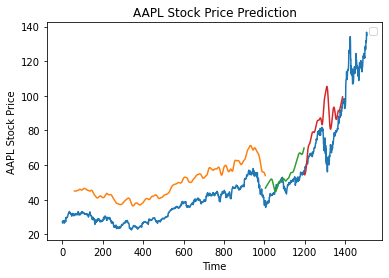

In [ ]:
#need to include validation 
plot_data(close_data,look_back=60,train_predict=train_predict,test_predict=test_predict,val_predict=val_predict)

# Stacked LSTM

In [ ]:
# Uses the same preprocessing as LSTM
#Example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"

#load data 
data_load_and_split(company,start,end)

[*********************100%***********************]  1 of 1 completed
Orignal data shape: (1509, 7) 
 Close Dataframe shape: (1509, 1) 
 Training set shape: (1006, 1) 
 Validation set shape: (252, 1) 
 Testing set shape: (251, 1)


In [ ]:
# Scaling data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

#create training data
train_scaled = scaler.fit_transform(train)
train_supervised = supervised(train_scaled)
X_train, y_train = split_and_reshape(train_supervised)

# create validation data
val_scaled = scaler.fit_transform(val) 
val_supervised = supervised(val_scaled)
X_val, y_val = split_and_reshape(val_supervised)

# create test data
test_scaled = scaler.transform(test) # transform not fit_transform
test_supervised = supervised(test_scaled)
X_test, y_test = split_and_reshape(test_supervised)

X shape: (946, 60, 1) 
y shape: (946,)
X shape: (192, 60, 1) 
y shape: (192,)
X shape: (191, 60, 1) 
y shape: (191,)


In [ ]:
###create the stacked lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')#, metrics=[ 'accuracy'])

In [ ]:
# model summary and fit
model.summary()
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=100,batch_size=64,verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 7s 184ms/step - loss: 0.2012 - val_loss: 0.1143
Epoch 2/100
15/15 [==============================] - 2s 106ms/step - loss: 0.0542 - val_loss: 0.0433
Epoch 3/100
15/15 [===========================

In [ ]:
history.history

{'loss': [0.13683989644050598,
  0.05328100547194481,
  0.04260086268186569,
  0.03607867658138275,
  0.034311842173337936,
  0.032900985330343246,
  0.0302638690918684,
  0.03121836483478546,
  0.03116108663380146,
  0.028038781136274338,
  0.027467435225844383,
  0.026883326470851898,
  0.025917917490005493,
  0.02580343559384346,
  0.025835542008280754,
  0.02583286166191101,
  0.029723437502980232,
  0.02694140188395977,
  0.025185611099004745,
  0.02396615780889988,
  0.025236353278160095,
  0.02438473515212536,
  0.02675500512123108,
  0.0279278252273798,
  0.023566562682390213,
  0.022841282188892365,
  0.022959360852837563,
  0.021584423258900642,
  0.020960072055459023,
  0.021982993930578232,
  0.020442819222807884,
  0.020630937069654465,
  0.019073575735092163,
  0.018664799630641937,
  0.018200214952230453,
  0.01852368749678135,
  0.018981004133820534,
  0.01833365485072136,
  0.017927095293998718,
  0.017986668273806572,
  0.017293989658355713,
  0.017955482006072998,
  

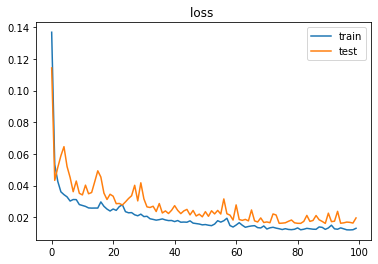

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss ')
plt.legend()
plt.show()

In [ ]:
#predictions and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

# invert dataset and predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])
val_predict = scaler.inverse_transform(val_predict)
val_y = scaler.inverse_transform([y_val])

#forecast_predict = scaler.inverse_transform(forecast_predict)
train_score = np.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = np.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

Train Score: 0.69 RMSE
Test Score: 5.73 RMSE


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
No handles with labels found to put in legend.


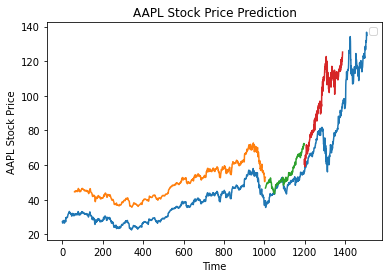

In [ ]:
plot_data(close_data,look_back=60,train_predict=train_predict,test_predict=test_predict, val_predict=val_predict)

In [ ]:
#show actual and predicted price
plt.plot(inv_y,  label = company + ' actual close')
plt.plot(inv_test,  label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
plt.plot(inv_y[:100], label = company + ' actual close')
plt.plot(inv_test[:100], label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

# Attention-Based LSTM

In [ ]:
data_load_and_split(company,start,end)

In [ ]:
close_data

# Linear regression

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
data = stock
plt.figure(figsize=(10, 5))
data['Close'].plot()

In [ ]:
data = data.reset_index()
x = np.array(data.index).reshape(-1, 1)
y = data['Close']

linreg = LinearRegression().fit(x, y)
linreg.score(x, y)
predictions = linreg.predict(x)

plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.plot(data.index, predictions)

##Linear Regression optimization using polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [ ]:
data = data.reset_index()
x = np.array(data.index).reshape(-1, 1)
y = data['Close']

In [ ]:
rmses = []
degrees = np.arange(1, 30)
r2, min_deg, min_rmse = 0, 0, 1e10

for deg in degrees:
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly = poly_features.fit_transform(x)
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly, y)
    y_predict = poly_reg.predict(x_poly)
    poly_mse = mean_squared_error(y, y_predict)
    poly_rmse = np.sqrt(poly_mse)
    poly_r2 = r2_score(y, y_predict)
    #r2.append(poly_r2)
    rmses.append(poly_rmse)
    # Cross-validation of degree
    if min_rmse > poly_rmse :
        min_rmse = poly_rmse
        r2 = poly_r2
        min_deg = deg
        p = y_predict
print('Best degree {} with R^2: {} and RMSE: {}'.format(min_deg, r2, min_rmse))
plt.figure(figsize=(15,5))
plt.plot(data.index,y,label='Actual')
plt.plot(data.index,p,label='Predict')
plt.title('Degree {}\n R^2:  '.format(min_deg)+ str(round(r2,5)))
plt.legend()
plt.show()

# ARIMA

## Load data and data split function (train,test)

In [ ]:
def data_load_and_train_test_split(company, start, end):
  '''
  loads data from yfinance and splits into training, validation and testing sets

  Creates variables: stock, train, val and test
  '''

  global stock, close_data, train, test

  # load data and create a new index
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)

  # create dataframe of 'Date' and 'Close'
  close_data = stock[['Date', 'Close']]

  # create splits 
  train = close_data[close_data['Date']< datetime.datetime(2020,1,1)]
  test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

  # remove 'Date' column so we are left with the 'Close' data
  close_data = close_data.filter(['Close'])
  train = train.filter(['Close'])
  test = test.filter(['Close'])

  return print('Orignal data shape:', stock.shape, '\n',
               'Close Dataframe shape:', close_data.shape, '\n',
               'Training set shape:', train.shape, '\n',
               'Testing set shape:', test.shape)

In [ ]:
#example
company = 'MSFT'
start = "2015-01-01"
end="2020-12-30"
data_load_and_train_test_split(company,start,end)

## num diff

In [ ]:
# estimate the number of differencing.
def num_diff(stock):
  from pmdarima.arima.utils import ndiffs
  from statsmodels.compat.pandas import Appender
  kpss_diffs = ndiffs(stock, test='kpss')
  adf_diffs = ndiffs(stock, test="adf")
  return max(adf_diffs, kpss_diffs)

In [ ]:
#example
n_diffs = num_diff(close_data)

##check if stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def test_stationarity(timeseries):
 #Determing rolling statistics
 rolmean = timeseries.rolling(12).mean()
 rolstd = timeseries.rolling(12).std()

 plt.plot(timeseries, color='blue',label='Original')
 plt.plot(rolmean, color='red', label='Rolling Mean')
 plt.plot(rolstd, color='black', label = 'Rolling Std')
 plt.legend(loc='best')
 plt.title('Rolling Mean and Standard Deviation')
 plt.show(block=False)
 
 '''
 if test statistics is bigger than critical value and p-value is bigger than 0.05
 then this timeseries is not stationary
 '''
 print('Results of dickey fuller test')
 adft = adfuller(timeseries,autolag='AIC')
 output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
 for key,values in adft[4].items():
  output['critical value (%s)'%key] = values
 print(output)
 
test_stationarity(train)

In [ ]:
#remove seasonality
train_log_diff = train_log - train_log.shift(n_diffs) 
test_stationarity(train_log_diff.dropna())

## auto arima

In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [ ]:
def arima_auto(stock):
  from pmdarima.arima import auto_arima
  global arima_model
  arima_model = auto_arima(
      stock,
      start_p=0,
      start_q=0,
      test="adf",
      max_p=6,
      max_q=6,
      m=1,  # frequency of series
      d=n_diffs, 
      seasonal=False,  # no seasonality
      trace=True,
      stepwise=True,
      njob=-1,
  )
  print(arima_model.summary())
  return arima_model

In [ ]:
#example
arima_model = arima_auto(train_log_diff.dropna())

## arima model fit

In [ ]:
test[0:1]

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)

In [ ]:
#values
train = train.values

# Create list of x train values
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)

# loop through every data point
for time_point in list(test.index):
    model = ARIMA(history, order=arima_model.order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point-1258:time_point-1257]
    history.append(true_test_value)

In [ ]:
RMSE_error = np.sqrt(mean_squared_error(test, model_predictions))
print('Test Score: %.2f RMSE' % RMSE_error)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(test.index[-100:], test[-100:], color='red', label='Actual Price')
plt.title(company + ' Prices Prediction')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [ ]:
plt.plot(train, label='training data')
plt.plot(test, label='actual price')
plt.plot(test.index[-len(test):],model_predictions[-len(test):], label='predicted price')
plt.ylabel('Price')
plt.title(company + ' Prices Prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
import math
import plotly.graph_objects as go
from pylab import rcParams
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
rcParams['figure.figsize'] = 25, 8

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

valuessarima =close_data.values
train = train.values
test = test.values

result = seasonal_decompose(valuessarima, model='multiplicative', freq=365)
fig = result.plot()
plt.show()


In [ ]:
history = [x for x in train]
y = test

# Make first prediction
predictions = list()
model = ARIMA(train, order=(0, 1, 0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0][0]
predictions.append(yhat)
history.append(y[0])

# Rolling forecasts
for i in range(1, len(y)):
     # Predict
     model = ARIMA(train, order=(0, 1, 0))
     model_fit = model.fit(disp=0)
     yhat = model_fit.forecast()[0][0]
     # Invert transformed prediction
     predictions.append(yhat)
     # Observation
     obs = y[i]
     history.append(obs)

# Report performance
mse = mean_squared_error(y, predictions)
print('MSE: ' + str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: ' + str(rmse))

In [ ]:
# Plotting ARIMA result
fig = go.Figure()

fig.add_trace(go.Scatter(x=train[-250:], y=train[250:], mode='lines', name='Price'))
fig.add_trace(go.Scatter(x=test, y=test, mode='lines', name='Test price'))
fig.add_trace(go.Scatter(x=test, y=predictions, mode='lines', name='Predicted price'))

fig.update_layout(autosize=True, width=1450, height=825,
    title_font=dict(size=25, family='Courier', color='crimson'),
    title="ARIMA prediction - Close Price",
)

fig.show()